# Triplet Loss for Implicit Feedback Neural Recommender Systems

Goals:
- Understand bi-linear recommendation system only using positive feedback data
- Use Margin Based Comparator / Triplet Loss
- Build deep learning architecture using similar deign principle

This notebook is inspired by Oliver Grisel Notebook who used Keras
https://github.com/ogrisel for building the moels. We will be using Basic Tensorflow APIs instead. You can also look into Maciej Kula's work [Recommendations in Keras using triplet loss](
https://github.com/maciejkula/triplet_recommendations_keras) that uses BPR ( Bayesian Personalized Ranking ). 


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import os.path as op
from sklearn.metrics import roc_auc_score
from tensorflow.contrib import layers
import tensorflow as tf
print(tf.__version__)

1.5.0


In [3]:
# Base Path for MovieLens dataset
ML_100K_PATH = os.path.join('processed','ml-100k','ml-100k')

data_train = pd.read_csv(op.join(ML_100K_PATH, 'ua.base'), sep='\t',
                        names=["user_id", "item_id", "rating", "timestamp"])
data_test = pd.read_csv(op.join(ML_100K_PATH, 'ua.test'), sep='\t',
                        names=["user_id", "item_id", "rating", "timestamp"])

data_train.describe()

,user_id,item_id,rating,timestamp
count,90570.000000,90570.000000,90570.000000,9.057000e+04
mean,461.494038,428.104891,3.523827,8.835073e+08
std,266.004364,333.088029,1.126073,5.341684e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,256.000000,174.000000,3.000000,8.794484e+08
50%,442.000000,324.000000,4.000000,8.828143e+08
75%,682.000000,636.000000,4.000000,8.882049e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


In [4]:
def get_release_year(x):
    splits = str(x).split('-')
    if(len(splits) == 3):
        return int(splits[2])
    else:
        return 1920
    

m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(op.join(ML_100K_PATH, 'u.item'), sep='|',
                    names=m_cols, usecols=range(5), encoding='latin-1')
items['release_year'] = items['release_date'].map(get_release_year)

data_train = pd.merge(data_train, items)
data_test = pd.merge(data_test, items)

In [5]:
data_train.head()

,user_id,item_id,rating,timestamp,title,release_date,video_release_date,imdb_url,release_year
0,1,1,5,874965758,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
1,2,1,4,888550871,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
2,6,1,4,883599478,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
3,10,1,4,877888877,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
4,13,1,3,882140487,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995


In [6]:
max_user_id = max(data_train['user_id'].max(), data_test['user_id'].max())
max_item_id = max(data_train['item_id'].max(), data_test['item_id'].max())

n_users = max_user_id + 1
n_items = max_item_id + 1

print('n_users=%d, n_items=%d' % (n_users, n_items))

n_users=944, n_items=1683


## Implicit feedback data

Consider ratings >= 4 as positive feed back and ignore the rest:

3.5238268742409184


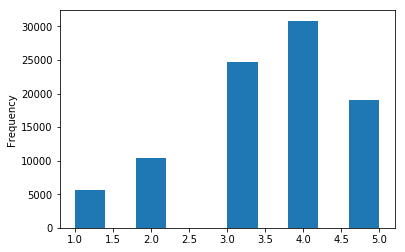

In [7]:
data_train['rating'].plot(kind='hist');
print(data_train['rating'].mean())

In [8]:
pos_data_train = data_train.query("rating >= 4")
pos_data_test = data_test.query("rating >= 4")

Because the mean rating is around 3.5, this cut will remove approximately half of the ratings from the datasets:

In [9]:
pos_data_train['rating'].count()

49906

In [10]:
pos_data_test['rating'].count()

5469

## The Triplet Loss

The following section demonstrates how to build a low-rank quadratic interaction model between users and items. The similarity score between a user and an item is defined by the unormalized dot products of their respective embeddings.

The matching scores can be use to rank items to recommend to a specific user.

Training of the model parameters is achieved by randomly sampling negative items not seen by a pre-selected anchor user. We want the model embedding matrices to be such that the similarity between the user vector and the negative vector is smaller than the similarity between the user vector and the positive item vector. Furthermore we use a margin to further move appart the negative from the anchor user.

Here is the architecture of such a triplet architecture. The triplet name comes from the fact that the loss to optimize is defined for triple `(anchor_user, positive_item, negative_item)`:

<img src="images/rec_archi_implicit_2.svg" style="width: 600px;" />

We call this model a triplet model with bi-linear interactions because the similarity between a user and an item is captured by a dot product of the first level embedding vectors. This is therefore not a deep architecture.

Here is the actual code that builds the model(s) with shared weights. Note that here we use the cosine similarity instead of unormalized dot products (both seems to yield comparable results).

## Quality of Ranked Recommendations

Now that we have a randomly initialized model we can start computing random recommendations. To assess their quality we do the following for each user:

- compute matching scores for items (except the movies that the user has already seen in the training set),
- compare to the positive feedback actually collected on the test set using the ROC AUC ranking metric,
- average ROC AUC scores across users to get the average performance of the recommender model on the test set.

By default the model should make predictions that rank the items in random order. The **ROC AUC score** is a ranking score that represents the **expected value of correctly ordering uniformly sampled pairs of recommendations**.

A random (untrained) model should yield 0.50 ROC AUC on average. 

In [11]:
embedding_size = 64 # embedding size
reg_param = 0.01 # regularization parameter lambda
learning_rate = 0.01 # learning rate 
margin = 1.0 # margin 

# create tensorflow graph
g = tf.Graph()
with g.as_default():
    
    # setting up random seed
    tf.set_random_seed(1234)
    
    # placeholders
    user_input = tf.placeholder(shape=[None], dtype=tf.int64)
    positive_item_input = tf.placeholder(shape=[None], dtype=tf.int64)
    negative_item_input = tf.placeholder(shape=[None], dtype=tf.int64)
    
    # variables
    with tf.variable_scope("embedding"):
        user_weight = tf.get_variable("user_w"
                                      , shape=[max_user_id + 1, embedding_size]
                                      , dtype=tf.float32
                                      , initializer=layers.xavier_initializer())

        item_weight = tf.get_variable("item_w"
                                       , shape=[max_item_id + 1, embedding_size]
                                       , dtype=tf.float32
                                       , initializer=layers.xavier_initializer())
    # embedding
    with tf.name_scope("embedding"):
        user_embedding = tf.nn.embedding_lookup(user_weight, user_input)
        positive_item_embedding = tf.nn.embedding_lookup(item_weight, positive_item_input)
        negative_item_embedding = tf.nn.embedding_lookup(item_weight, negative_item_input)
     
     # similarity
    with tf.name_scope("similarity"):
        positive_similarity = tf.reduce_sum(tf.multiply(user_embedding, positive_item_embedding), 1) 
        negative_similarity = tf.reduce_sum(tf.multiply(user_embedding, negative_item_embedding), 1) 
        
    # loss 
    with tf.name_scope("loss"):
        triplet_loss = tf.maximum(negative_similarity - positive_similarity + margin, 0)
        loss = tf.reduce_mean(triplet_loss)
        train_ops = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        
    
    

In [12]:
def sample_triplets(pos_data, max_item_id, random_seed=0):
    """Sample negatives at random"""
    rng = np.random.RandomState(random_seed)
    user_ids = pos_data['user_id'].values
    pos_item_ids = pos_data['item_id'].values

    neg_item_ids = rng.randint(low=1, high=max_item_id + 1,
                               size=len(user_ids))
    return [ user_ids, pos_item_ids,neg_item_ids]

## Training the Triplet Model

Let's now fit the parameters of the model by sampling triplets: for each user, select a movie in the positive feedback set of that user and randomly sample another movie to serve as negative item.

Note that this sampling scheme could be improved by removing items that are marked as positive in the data to remove some label noise. In practice this does not seem to be a problem though.

Let's train the triplet model:

In [13]:
n_epochs = 1000
losses_train = []
losses_val = []
    
with tf.Session(graph=g) as sess:
    # initializer
    sess.run(tf.global_variables_initializer())
    
    def check_overfit(validation_loss):
        n = len(validation_loss)
        if n < 5:
            return False
        count = 0 
        for i in range(n-4, n):
            if validation_loss[i] < validation_loss[i-1]:
                count += 1
            if count >=2:
                return False
        return True
            
    for i in range(n_epochs):
        triplet_inputs_train = sample_triplets(pos_data_train, max_item_id,random_seed=i)
        triplet_inputs_val = sample_triplets(pos_data_test, max_item_id,random_seed=i+1)
        
        train_input_dict = {user_input: triplet_inputs_train[0]
                            , positive_item_input: triplet_inputs_train[1]
                            , negative_item_input: triplet_inputs_train[2]}
        
        val_input_dict = {user_input: triplet_inputs_val[0]
                            , positive_item_input: triplet_inputs_val[1]
                            , negative_item_input: triplet_inputs_val[2]}
        sess.run([train_ops], feed_dict=train_input_dict)
        
        if i % 10 == 0:
            loss_train = sess.run(loss, feed_dict=train_input_dict)
            loss_val = sess.run(loss, feed_dict=val_input_dict)

            losses_train.append(loss_train)
            losses_val.append(loss_val)

            # check early stopping 
            if(check_overfit(losses_val)):
                print('overfit !')
                break

             
            # calculate AUC Score 
            """Compute the ROC AUC for each user and average over users"""
            max_user_id = max(pos_data_train['user_id'].max(), pos_data_test['user_id'].max())
            max_item_id = max(pos_data_train['item_id'].max(), pos_data_test['item_id'].max())
            user_auc_scores = []
            for user_id in range(1, max_user_id + 1):
                pos_item_train = pos_data_train[pos_data_train['user_id'] == user_id]
                pos_item_test = pos_data_test[pos_data_test['user_id'] == user_id]

                # Consider all the items already seen in the training set
                all_item_ids = np.arange(1, max_item_id + 1)
                items_to_rank = np.setdiff1d(all_item_ids, pos_item_train['item_id'].values)

                # Ground truth: return 1 for each item positively present in the test set
                # and 0 otherwise.
                expected = np.in1d(items_to_rank, pos_item_test['item_id'].values)

                if np.sum(expected) >= 1:
                    # At least one positive test value to rank
                    repeated_user_id = np.empty_like(items_to_rank)
                    repeated_user_id.fill(user_id)
                    predicted = sess.run(positive_similarity, feed_dict={user_input : repeated_user_id, 
                                                            positive_item_input : items_to_rank})
                    user_auc_scores.append(roc_auc_score(expected, predicted))

            print("iteration : %d train loss: %.3f , valid loss %.3f , ROC auc %.4f" % (i,loss_train, loss_val,np.mean(user_auc_scores)))


iteration : 0 train loss: 0.992 , valid loss 1.000 , ROC auc 0.5014
iteration : 10 train loss: 0.670 , valid loss 0.751 , ROC auc 0.8609
iteration : 20 train loss: 0.325 , valid loss 0.361 , ROC auc 0.8819
iteration : 30 train loss: 0.273 , valid loss 0.283 , ROC auc 0.9002
iteration : 40 train loss: 0.223 , valid loss 0.237 , ROC auc 0.9179
iteration : 50 train loss: 0.194 , valid loss 0.226 , ROC auc 0.9238
iteration : 60 train loss: 0.172 , valid loss 0.233 , ROC auc 0.9257
iteration : 70 train loss: 0.159 , valid loss 0.219 , ROC auc 0.9264
iteration : 80 train loss: 0.146 , valid loss 0.236 , ROC auc 0.9257
iteration : 90 train loss: 0.135 , valid loss 0.236 , ROC auc 0.9246
iteration : 100 train loss: 0.126 , valid loss 0.248 , ROC auc 0.9236
iteration : 110 train loss: 0.120 , valid loss 0.242 , ROC auc 0.9224
iteration : 120 train loss: 0.116 , valid loss 0.268 , ROC auc 0.9211
iteration : 130 train loss: 0.110 , valid loss 0.242 , ROC auc 0.9197
iteration : 140 train loss: 0.1

## Training a Deep Matching Model on Implicit Feedback


Instead of using hard-coded cosine similarities to predict the match of a `(user_id, item_id)` pair, we can instead specify a deep neural network based parametrisation of the similarity. The parameters of that matching model are also trained with the margin comparator loss:

<img src="images/rec_archi_implicit_1.svg" style="width: 600px;" />




In [14]:
user_embedding_size = 32
item_embedding_size = 64
num_hidden = 64

reg_param = 0.01
learning_rate = 0.01
n_users = max_user_id + 1
n_items = max_item_id + 1

g = tf.Graph()
with g.as_default():
    
    # setting up random seed
    tf.set_random_seed(1234)

    user_input = tf.placeholder(shape=[None,1], dtype=tf.int64, name='user_input')
    positive_item_input = tf.placeholder(shape=[None,1], dtype=tf.int64, name='positive_item_input')
    negative_item_input = tf.placeholder(shape=[None,1], dtype=tf.int64, name='negative_item_input')
    
    l2_loss = tf.constant(0.0)
    
    # embeddding layer
    with tf.variable_scope("embedding"):
        user_weights = tf.get_variable("user_w"
                                      , shape=[n_users, user_embedding_size]
                                      , dtype=tf.float32
                                      , initializer=layers.xavier_initializer())
        
        item_weights = tf.get_variable("item_w"
                                       , shape=[n_items, item_embedding_size]
                                       , dtype=tf.float32
                                       , initializer=layers.xavier_initializer())
        
        user_embedding = tf.squeeze(tf.nn.embedding_lookup(user_weights, user_input),axis=1, name='user_embedding')
        positive_item_embedding = tf.squeeze(tf.nn.embedding_lookup(item_weights, positive_item_input),axis=1, name='positive_item_embedding')
        negative_item_embedding = tf.squeeze(tf.nn.embedding_lookup(item_weights, negative_item_input),axis=1, name='negative_item_embedding')
        
        l2_loss += tf.nn.l2_loss(user_weights)
        l2_loss += tf.nn.l2_loss(item_weights)
        
        
        print(user_embedding)
        print(positive_item_embedding)
        print(negative_item_embedding)
        
    
    # combine inputs
    with tf.name_scope('concatenation'):
        positive_embeddings_pair = tf.concat([user_embedding, positive_item_embedding], axis=1)
        negative_embeddings_pair = tf.concat([user_embedding, negative_item_embedding], axis=1)
        print(positive_embeddings_pair)
        print(negative_embeddings_pair)
        
    # fc-1
    
    with tf.name_scope("fc_1"):
        W_fc_1 = tf.get_variable(
            "W_hidden",
            shape=[user_embedding_size + item_embedding_size, num_hidden],
            initializer=tf.contrib.layers.xavier_initializer())
        b_fc_1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="b")
        hidden_output_positive = tf.nn.relu(tf.nn.xw_plus_b(positive_embeddings_pair, W_fc_1, b_fc_1), name='hidden_output_positive')
        hidden_output_negative = tf.nn.relu(tf.nn.xw_plus_b(negative_embeddings_pair, W_fc_1, b_fc_1), name='hidden_output_negative')
        
        l2_loss += tf.nn.l2_loss(W_fc_1)
        print(hidden_output_positive)
        print(hidden_output_negative)
        
    # dropout
    with tf.name_scope("dropout"):
        h_drop_positive = tf.nn.dropout(hidden_output_positive, 0.8, name="hidden_output_drop_positive")
        h_drop_negative = tf.nn.dropout(hidden_output_negative, 0.8, name="hidden_output_drop_negative")
        print(h_drop_positive)
        print(h_drop_negative)
    
    # fc-2
    with tf.name_scope("fc_2"):
        W_fc_2 = tf.get_variable(
            "W_output",
            shape=[num_hidden,1],
            initializer=tf.contrib.layers.xavier_initializer())
        b_fc_2 = tf.Variable(tf.constant(0.1, shape=[1]), name="b")
        positive_prediction = tf.nn.xw_plus_b(h_drop_positive, W_fc_2, b_fc_2, name='positive_prediction')
        negative_prediction = tf.nn.xw_plus_b(h_drop_negative, W_fc_2, b_fc_2, name='negative_prediction')
        
        l2_loss += tf.nn.l2_loss(W_fc_2)
        print(positive_prediction)
        print(negative_prediction)

    # loss
    with tf.name_scope("loss"):
        triplet_loss = tf.maximum(negative_prediction - positive_prediction + margin, 0)
        loss = tf.reduce_mean(triplet_loss) + reg_param * l2_loss
        train_ops = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        

Tensor("embedding/user_embedding:0", shape=(?, 32), dtype=float32)
Tensor("embedding/positive_item_embedding:0", shape=(?, 64), dtype=float32)
Tensor("embedding/negative_item_embedding:0", shape=(?, 64), dtype=float32)
Tensor("concatenation/concat:0", shape=(?, 96), dtype=float32)
Tensor("concatenation/concat_1:0", shape=(?, 96), dtype=float32)
Tensor("fc_1/hidden_output_positive:0", shape=(?, 64), dtype=float32)
Tensor("fc_1/hidden_output_negative:0", shape=(?, 64), dtype=float32)
Tensor("dropout/hidden_output_drop_positive/mul:0", shape=(?, 64), dtype=float32)
Tensor("dropout/hidden_output_drop_negative/mul:0", shape=(?, 64), dtype=float32)
Tensor("fc_2/positive_prediction:0", shape=(?, 1), dtype=float32)
Tensor("fc_2/negative_prediction:0", shape=(?, 1), dtype=float32)


In [15]:
n_epochs = 1000
losses_train = []
losses_val = []

with tf.Session(graph=g) as sess:
    # initializer
    sess.run(tf.global_variables_initializer())
    
    def check_overfit(validation_loss):
        n = len(validation_loss)
        if n < 5:
            return False
        count = 0 
        for i in range(n-4, n):
            if validation_loss[i] < validation_loss[i-1]:
                count += 1
            if count >=3:
                return False
        return True
            
    for i in range(n_epochs):
        triplet_inputs_train = sample_triplets(pos_data_train, max_item_id,random_seed=i)
        triplet_inputs_val = sample_triplets(pos_data_test, max_item_id,random_seed=i+1)
        
        train_input_dict = {user_input: triplet_inputs_train[0].reshape([-1,1])
                            , positive_item_input: triplet_inputs_train[1].reshape([-1,1])
                            , negative_item_input: triplet_inputs_train[2].reshape([-1,1])}
        
        val_input_dict = {user_input: triplet_inputs_val[0].reshape([-1,1])
                            , positive_item_input: triplet_inputs_val[1].reshape([-1,1])
                            , negative_item_input: triplet_inputs_val[2].reshape([-1,1])}
        sess.run([train_ops], feed_dict=train_input_dict)
        
        if i % 10 == 0:
            loss_train = sess.run(loss, feed_dict=train_input_dict)
            loss_val = sess.run(loss, feed_dict=val_input_dict)

            losses_train.append(loss_train)
            losses_val.append(loss_val)

            # check early stopping 
            if(check_overfit(losses_val)):
                print('overfit !')
                break

            
            # calculate AUC Score 
            """Compute the ROC AUC for each user and average over users"""
            max_user_id = max(pos_data_train['user_id'].max(), pos_data_test['user_id'].max())
            max_item_id = max(pos_data_train['item_id'].max(), pos_data_test['item_id'].max())
            user_auc_scores = []
            for user_id in range(1, max_user_id + 1):
                pos_item_train = pos_data_train[pos_data_train['user_id'] == user_id]
                pos_item_test = pos_data_test[pos_data_test['user_id'] == user_id]

                # Consider all the items already seen in the training set
                all_item_ids = np.arange(1, max_item_id + 1)
                items_to_rank = np.setdiff1d(all_item_ids, pos_item_train['item_id'].values)

                # Ground truth: return 1 for each item positively present in the test set
                # and 0 otherwise.
                expected = np.in1d(items_to_rank, pos_item_test['item_id'].values)

                if np.sum(expected) >= 1:
                    # At least one positive test value to rank
                    repeated_user_id = np.empty_like(items_to_rank)
                    repeated_user_id.fill(user_id)
                    predicted = sess.run(positive_prediction, feed_dict={user_input : repeated_user_id.reshape([-1,1]), 
                                                            positive_item_input : items_to_rank.reshape([-1,1])})
                    user_auc_scores.append(roc_auc_score(expected, predicted))

            print("iteration : %d train loss: %.3f , valid loss %.3f , ROC auc %.4f" % (i,loss_train, loss_val,np.mean(user_auc_scores)))


            
            




iteration : 0 train loss: 1.882 , valid loss 1.881 , ROC auc 0.6317
iteration : 10 train loss: 0.787 , valid loss 0.773 , ROC auc 0.8665
iteration : 20 train loss: 0.591 , valid loss 0.593 , ROC auc 0.8591
iteration : 30 train loss: 0.548 , valid loss 0.531 , ROC auc 0.8638
iteration : 40 train loss: 0.528 , valid loss 0.511 , ROC auc 0.8635
iteration : 50 train loss: 0.521 , valid loss 0.512 , ROC auc 0.8635
overfit !


## Possible Extensions

You can implement any of the following ideas if you want to get a deeper understanding of recommender systems.


### Leverage User and Item metadata

As we did for the Explicit Feedback model, it's also possible to extend our models to take additional user and item metadata as side information when computing the match score.


### Better Ranking Metrics

In this notebook we evaluated the quality of the ranked recommendations using the ROC AUC metric. This score reflect the ability of the model to correctly rank any pair of items (sampled uniformly at random among all possible items).

In practice recommender systems will only display a few recommendations to the user (typically 1 to 10). It is typically more informative to use an evaluatio metric that characterize the quality of the top ranked items and attribute less or no importance to items that are not good recommendations for a specific users. Popular ranking metrics therefore include the **Precision at k** and the **Mean Average Precision**.



### Hard Negatives Sampling

In this experiment we sampled negative items uniformly at random. However, after training the model for a while, it is possible that the vast majority of sampled negatives have a similarity already much lower than the positive pair and that the margin comparator loss sets the majority of the gradients to zero effectively wasting a lot of computation.

Given the current state of the recsys model we could sample harder negatives with a larger likelihood to train the model better closer to its decision boundary. This strategy is implemented in the WARP loss [1].

The main drawback of hard negative sampling is increasing the risk of sever overfitting if a significant fraction of the labels are noisy.

